In [1]:
# RFM定義  [2018/06/26~2020/01/20]       
# Recency = 最近消費日(距[2020/01/20]日期差)                 
# Frequency: 消費頻率 = 消費次數*距[2020/01/20]日期差倒數           
# Monetary Value = 消費金額*距[2020/01/20]日期差倒數         

# 只針對有消費過(Finish)的用戶，做RFM分群

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

df1 = pd.read_csv('dataset/Freq&Monetary.csv') 
df2 = pd.read_csv('dataset/LastPurchase_onlyFinish.csv')

df = pd.merge(df1,df2,on='MemberID', how='left')
print('df.shape', df.shape)
df = df.dropna()
print('df.shape', df.shape)
df = df[ df['Days'] < 365]
print('df.shape', df.shape)

recency = df['Days']
frequency = df['消費次數*日期差倒數']    
monetary = df['消費金額*日期差倒數']   

df.shape (173061, 8)
df.shape (173061, 8)
df.shape (60917, 8)


173061個會員
- 60916個會員近一年內有交易 (針對這些做k-means分群)
- 11萬個會員近一年內沒有交易

#### 分5群 by k-means

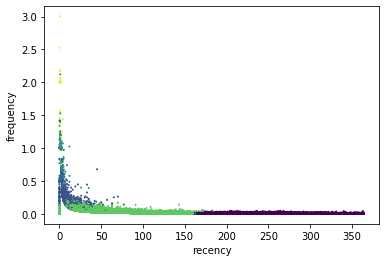

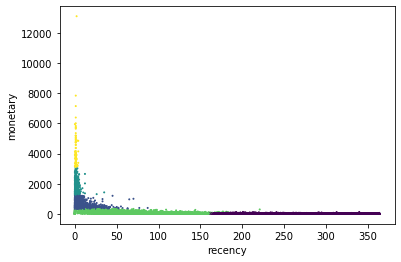

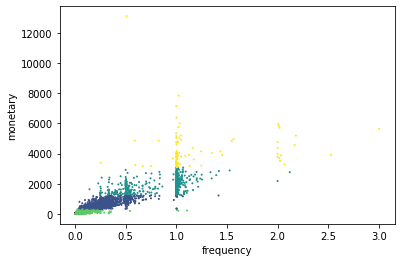

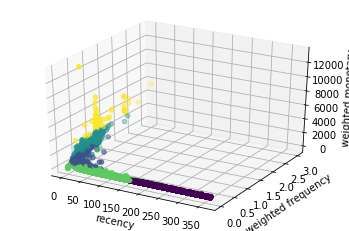

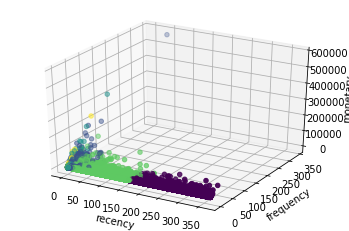

,MemberID,recency,frequency,monetary,clusterID,RegisterSourceTypeDef,RegisterDateTime,Gender,Birthday,IsAppInstalled,IsEnableEmail,IsEnablePushNotification,IsEnableShortMessage,MemberCardLevel,eland_uuid
0,JAE7ypAI%2BmBkMAd1REpPJI3zcEQBI9WBTeg5QlsEri4%3D,116.0,0.008621,5.862069,3,Web,27:32.6,NaN,1900/1/1,False,True,True,True,10.0,NaN
1,UB%2F0WwXAdW5GhwWmVB036mhSMcUnbK1IA5kXp31h4XQ%3D,116.0,0.008621,23.793103,3,Web,46:59.3,Female,1988/4/21,True,True,True,True,10.0,NaN
2,rKUVLmkXyUqqVN8zU1UB40kuhBLRok8FvQtDZTGIS00%3D,114.0,0.024216,40.005612,3,NaN,07:07.6,Female,1984/9/18,True,True,True,True,20.0,5418BC52-2F6B-460E-9369-46ACE7D7E53E
3,rKUVLmkXyUqqVN8zU1UB40kuhBLRok8FvQtDZTGIS00%3D,114.0,0.024216,40.005612,3,NaN,07:07.6,Female,1984/9/18,True,True,True,True,20.0,d0e44fb660694494b62c349817abb8bc122414
4,rKUVLmkXyUqqVN8zU1UB40kuhBLRok8FvQtDZTGIS00%3D,114.0,0.024216,40.005612,3,NaN,07:07.6,Female,1984/9/18,True,True,True,True,20.0,f7c4c33665c84570bfb8dd49d21a4fc3112023


In [2]:
'''K-means'''
from sklearn.cluster import KMeans

X = np.vstack((recency,frequency,monetary)).T

y_pred = KMeans(n_clusters=5, random_state=9 ).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c= y_pred, s=1);plt.xlabel('recency');plt.ylabel('frequency');plt.show()
plt.scatter(X[:, 0], X[:, 2], c= y_pred, s=1);plt.xlabel('recency');plt.ylabel('monetary');plt.show()
plt.scatter(X[:, 1], X[:, 2], c= y_pred, s=1);plt.xlabel('frequency');plt.ylabel('monetary');plt.show()

fig4 = plt.figure()
ax4 = plt.axes(projection='3d')
ax4.set_xlabel('recency');ax4.set_ylabel('weighted frequency');ax4.set_zlabel('weighted monetary')
ax4.scatter(X[:, 0], X[:, 1], X[:,2], c= y_pred)

plt.savefig('5clusters_2.png', dpi = 800, s=0.8)
plt.show()


fig4 = plt.figure()
ax4 = plt.axes(projection='3d')
ax4.set_xlabel('recency');ax4.set_ylabel('frequency');ax4.set_zlabel('monetary')
ax4.scatter(X[:, 0], df['消費次數'], df['消費金額'], c= y_pred)
plt.savefig('5clusters_1.png', dpi = 800, s=0.8)
plt.show()


cluster_df = pd.DataFrame({'MemberID': df['MemberID'],
                           'recency': X[:,0], 'frequency':X[:,1], 
                           'monetary':X[:,2],  'clusterID': y_pred})

# merge MemberID & eland_uuid 
MemberData = pd.read_csv('91ForNTUDataSet/MemberData.csv')
cluster_df1 = pd.merge(cluster_df, MemberData, on='MemberID', how='left')
cluster_df1.head()

clusterID            
5: 近一年內沒有交易的11萬個會員         
0: 紫色 (流失會員)           
3: 綠色(潛力新客)         
1: 藍色 (潛力舊客)        
2: 藍綠色(活躍會員)           
4: 黃色 (高價活躍VIP)

##### contingency table + chi-square test

In [58]:
from scipy import stats

categorical_features = ['RegisterSourceTypeDef','Gender','IsAppInstalled','IsEnableEmail','IsEnablePushNotification','IsEnableShortMessage','MemberCardLevel']

for f in categorical_features:
    p_table1 = pd.crosstab(cluster_df1["clusterID"], cluster_df1[f], rownames=['clusterID'], colnames=[f]).apply(lambda r: r/r.sum(), axis=1).T #轉成機率(in each cluster)
    print(p_table1)
    table1 = pd.crosstab(cluster_df1["clusterID"], cluster_df1[f], rownames=['clusterID'], colnames=[f])
    chi2, p, dof, ex = stats.chi2_contingency(table1)  #卡方值，P值，自由度，與原數據數組同維度的對應理論值
    print(f, 'chi-square test\n', chi2, p,'\n\n')  

clusterID                     0         1         2         3         4
RegisterSourceTypeDef                                                  
AndroidApp             0.112489  0.106038  0.135475  0.077911  0.284672
LocationWizard         0.194332  0.218113  0.177374  0.142525  0.153285
Store                  0.010816  0.009057  0.001397  0.342529  0.000000
Web                    0.452336  0.436226  0.442737  0.287208  0.240876
iOSApp                 0.230026  0.230566  0.243017  0.149827  0.321168
RegisterSourceTypeDef chi-square test
 12650.608908651335 0.0 


clusterID         0         1         2         3    4
Gender                                                
Female     0.987501  0.991898  0.995327  0.987596  1.0
Male       0.012499  0.008102  0.004673  0.012404  0.0
Gender chi-square test
 8.162827881062116 0.0857924404581336 


clusterID              0         1        2         3         4
IsAppInstalled                                                 
False           0.2